### Here is the code for a focussed run where I used only data augumented dataset and no filter organisation strategy, lesser epochs and sweep count

Install Wandb if not present

In [8]:
!pip install wandb

Make necessary imports

In [4]:
import os
import numpy as np
import zipfile
import requests
from tqdm import tqdm
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim
from pathlib import Path
import json
import wandb

important global constants

In [5]:
dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
dataset_zip_path = "/kaggle/working/nature_12K.zip"
dataset_dir = "nature_12K"

### Download the dataset

In [6]:
if not os.path.exists(dataset_dir):
    if not os.path.exists(dataset_zip_path):
        print("Downloading iNaturalist-12K...")
        response = requests.get(dataset_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(dataset_zip_path, 'wb') as f, tqdm(
            desc=dataset_zip_path,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)

/kaggle/working/nature_12K.zip: 100%|██████████| 3.55G/3.55G [00:36<00:00, 103MiB/s] 


### Extract the dataset

In [7]:
if not os.path.exists(dataset_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

Extracting dataset...


### Make loader variables out of the dataset

In [8]:
def prepare_datasets(data_dir, val_split=0.2, batch_size=32, image_size=(224, 224)):
    data_dir = Path(data_dir)

    # Define transforms (customize as needed)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Converts to [0, 1] and CxHxW
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize RGB
    ])

    # Load training and testing datasets
    full_train_dataset = ImageFolder(root=data_dir / "train", transform=transform)
    test_dataset = ImageFolder(root=data_dir / "val", transform=transform)

    # Create validation split from training set
    val_size = int(val_split * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size

    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Extract X and Y by iterating over DataLoader batches if needed
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # Convert to X, Y tensors
    def extract_XY(loader):
        for X, Y in loader:
            return X, Y

    X_train, Y_train = extract_XY(train_loader)
    X_val, Y_val = extract_XY(val_loader)
    X_test, Y_test = extract_XY(test_loader)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [17]:
# dataset_dir = "/kaggle/working/inaturalist_12K"

In [ ]:
# X_train, Y_train, X_val, Y_val, X_test, Y_test = prepare_datasets(
#     data_dir='/kaggle/working/inaturalist_12K', val_split=0.2, batch_size=64, image_size=(224, 224)
# )

In [ ]:
# print(X_train.shape)

# Part A
### Question 1

Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer.

After 5 such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing 10 neurons. The input layer should be compatible with the images in the iNaturalist dataset dataset.
The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.

In [9]:
api_key = "7040d84a3ed65a967eb3389dd6fe774b418576ed" 
wandb.login(key=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m004 (da24m004-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
class FlexibleCNN(nn.Module):
    def __init__(self, 
                 num_filters=32,  # number of filters in each conv layer
                 filter_size=3,   # size of filters (k x k)
                 activation='relu',  # activation function
                 dense_neurons=512,  # number of neurons in dense layer
                 input_channels=3,   # RGB images
                 num_classes=10,    # number of output classes
                 use_batch_norm=True,  # whether to use batch normalization
                 dropout_rate=0.2):  # dropout rate
        super(FlexibleCNN, self).__init__()
        
        # Store parameters for calculations
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.dense_neurons = dense_neurons
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        
        # Choose activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            self.activation = nn.GELU()
        elif activation.lower() == 'silu':
            self.activation = nn.SiLU()
        elif activation.lower() == 'mish':
            self.activation = nn.Mish()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        # Create 5 conv-activation-maxpool blocks
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        
        for _ in range(5):
            block = []
            # Conv layer
            block.append(nn.Conv2d(in_channels, num_filters, filter_size, padding=filter_size//2))
            
            # Batch normalization if enabled
            if use_batch_norm:
                block.append(nn.BatchNorm2d(num_filters))
            
            # Activation
            block.append(self.activation)
            
            # Max pooling
            block.append(nn.MaxPool2d(2, 2))
            
            # Dropout after pooling
            block.append(nn.Dropout2d(dropout_rate))
            
            self.conv_blocks.extend(block)
            in_channels = num_filters
        
        # Calculate the size of the flattened features after conv blocks
        # Assuming input size of 224x224 (standard for iNaturalist)
        self.flattened_size = num_filters * (224 // (2**5)) * (224 // (2**5))
        
        # Dense layers
        self.dense = nn.Sequential(
            nn.Linear(self.flattened_size, dense_neurons),
            self.activation,
            nn.Dropout(dropout_rate),  # Dropout before final layer
            nn.Linear(dense_neurons, num_classes)
        )
    
    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x
    
    def get_computations(self):
        """Calculate total number of computations"""
        # Computations in conv layers
        conv_computations = 0
        input_size = 224
        in_channels = 3
        
        for i in range(5):
            # Each conv layer
            conv_computations += (input_size * input_size * in_channels * 
                                self.num_filters * self.filter_size * self.filter_size)
            # Each maxpool reduces size by 2
            input_size = input_size // 2
            in_channels = self.num_filters
        
        # Computations in dense layers
        dense_computations = (self.flattened_size * self.dense_neurons +  # first dense layer
                            self.dense_neurons * 10)  # output layer
        
        return conv_computations + dense_computations
    
    def get_parameters(self):
        """Calculate total number of parameters"""
        # Parameters in conv layers
        conv_params = 0
        in_channels = 3
        
        for _ in range(5):
            # Each conv layer has (filter_size * filter_size * in_channels + 1) * num_filters parameters
            conv_params += (self.filter_size * self.filter_size * in_channels + 1) * self.num_filters
            # Batch norm parameters if enabled
            if self.use_batch_norm:
                conv_params += 2 * self.num_filters  # gamma and beta for each channel
            in_channels = self.num_filters
        
        # Parameters in dense layers
        dense_params = (self.flattened_size * self.dense_neurons + self.dense_neurons +  # first dense layer
                       self.dense_neurons * 10 + 10)  # output layer
        
        return conv_params + dense_params

Train function to train the model and log the model parameters

In [11]:
# Training loop
best_val_acc = 0
best_config = None

def train(config=None):
    # Initialize wandb
    with wandb.init(config=config):
        config = wandb.config
        
        # Set random seed for reproducibility
        torch.manual_seed(config.seed)
        np.random.seed(config.seed)
        
        # Data augmentation and normalization
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Load dataset
        train_dataset = datasets.ImageFolder(
            root='/kaggle/working/inaturalist_12K/train',
            transform=train_transform
        )
        
        # Split into train and validation
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use stratified split to maintain class balance
        train_indices, val_indices = train_test_split(
            list(range(len(train_dataset))),
            test_size=0.2,
            stratify=train_dataset.targets,
            random_state=config.seed
        )
        
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)
        
        train_loader = DataLoader(
            train_subset,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=4
        )
        
        val_loader = DataLoader(
            val_subset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=4
        )
        
        # Initialize model
        model = FlexibleCNN(
            num_filters=config.num_filters,
            filter_size=config.filter_size,
            activation=config.activation,
            dense_neurons=config.dense_neurons,
            use_batch_norm=config.use_batch_norm,
            dropout_rate=config.dropout_rate
        )
        
        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        # Format the run name
        run_name = f"nf_{config.num_filters}_fs_{config.filter_size}_act_{config.activation}_dn_{config.dense_neurons}_lr_{config.learning_rate}_bs_{config.batch_size}_bn_{config.use_batch_norm}_dr_{config.dropout_rate}"

        # Set the run name
        wandb.run.name = run_name
        
        
        
        for epoch in range(config.epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
                
                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            
            train_acc = 100. * train_correct / train_total
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()
            
            val_acc = 100. * val_correct / val_total
            
            # Log metrics to wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss / len(train_loader),
                "train_acc": train_acc,
                "val_loss": val_loss / len(val_loader),
                "val_acc": val_acc
            })
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')
                best_config = dict(config)
                with open('best_config.json', 'w') as f:
                    json.dump(best_config, f, indent=4)
            
            print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Acc: {val_acc:.2f}%')
            

In [15]:

# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
            'values': [16, 32, 64]
        },
        'filter_size': {
            'values': [3]
        },
        'activation': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'dense_neurons': {
            'values': [128, 256]
        },
        'learning_rate': {
            'min': 1e-4,
            'max': 1e-2
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'use_batch_norm': {
            'values': [True, False]
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.4]
        },
        'epochs': {
            'value': 5
        },
        'seed': {
            'value': 42
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="inaturalist-cnn-sweep_1")

# Run sweep
wandb.agent(sweep_id, train, count=20)

Create sweep with ID: snrlb7qq
Sweep URL: https://wandb.ai/da24m004-iitmaana/inaturalist-cnn-sweep_1/sweeps/snrlb7qq


wandb: Agent Starting Run: tpffs2zd with config:
wandb: 	activation: silu
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.008163142238472034
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3505
Epoch: 0, Batch: 100, Loss: 2.3464
Epoch: 0, Train Loss: 2.5707, Train Acc: 13.30%, Val Loss: 2.2294, Val Acc: 16.70%
Epoch: 1, Batch: 0, Loss: 2.2524
Epoch: 1, Batch: 100, Loss: 2.2624
Epoch: 1, Train Loss: 2.2626, Train Acc: 15.08%, Val Loss: 2.2052, Val Acc: 20.15%
Epoch: 2, Batch: 0, Loss: 2.2313
Epoch: 2, Batch: 100, Loss: 2.2656
Epoch: 2, Train Loss: 2.2543, Train Acc: 15.68%, Val Loss: 2.2068, Val Acc: 18.05%
Epoch: 3, Batch: 0, Loss: 2.2340
Epoch: 3, Batch: 100, Loss: 2.2818
Epoch: 3, Train Loss: 2.2426, Train Acc: 17.03%, Val Loss: 2.2023, Val Acc: 19.20%
Epoch: 4, Batch: 0, Loss: 2.3111
Epoch: 4, Batch: 100, Loss: 2.1455
Epoch: 4, Train Loss: 2.2263, Train Acc: 18.20%, Val Loss: 2.1807, Val Acc: 19.50%


epoch,▁▃▅▆█
train_acc,▁▄▄▆█
train_loss,█▂▂▁▁
val_acc,▁█▄▆▇
val_loss,█▅▅▄▁
epoch,4
train_acc,18.20228
train_loss,2.22627
val_acc,19.5
val_loss,2.18065


wandb: Agent Starting Run: 96p26s9y with config:
wandb: 	activation: gelu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0003527034907413603
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3570
Epoch: 0, Batch: 100, Loss: 2.4619
Epoch: 0, Batch: 200, Loss: 2.1866
Epoch: 0, Train Loss: 2.2302, Train Acc: 17.20%, Val Loss: 2.1096, Val Acc: 23.70%
Epoch: 1, Batch: 0, Loss: 2.0533
Epoch: 1, Batch: 100, Loss: 2.1282
Epoch: 1, Batch: 200, Loss: 2.0769
Epoch: 1, Train Loss: 2.1399, Train Acc: 22.02%, Val Loss: 2.0522, Val Acc: 26.10%
Epoch: 2, Batch: 0, Loss: 2.0877
Epoch: 2, Batch: 100, Loss: 2.2564
Epoch: 2, Batch: 200, Loss: 2.0931
Epoch: 2, Train Loss: 2.1016, Train Acc: 24.23%, Val Loss: 2.0019, Val Acc: 28.25%
Epoch: 3, Batch: 0, Loss: 2.1379
Epoch: 3, Batch: 100, Loss: 2.0273
Epoch: 3, Batch: 200, Loss: 2.0731
Epoch: 3, Train Loss: 2.0717, Train Acc: 25.45%, Val Loss: 1.9656, Val Acc: 31.00%
Epoch: 4, Batch: 0, Loss: 1.9129
Epoch: 4, Batch: 100, Loss: 2.0592
Epoch: 4, Batch: 200, Loss: 2.1326
Epoch: 4, Train Loss: 2.0516, Train Acc: 26.85%, Val Loss: 1.9449, Val Acc: 32.10%


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▃▅▇█
val_loss,█▆▃▂▁
epoch,4
train_acc,26.85336
train_loss,2.05156
val_acc,32.1
val_loss,1.94491


wandb: Agent Starting Run: aanw6cw5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.007369605220457174
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3043
Epoch: 0, Train Loss: 2.4560, Train Acc: 9.99%, Val Loss: 2.3028, Val Acc: 10.00%
Epoch: 1, Batch: 0, Loss: 2.3034
Epoch: 1, Train Loss: 2.3034, Train Acc: 9.26%, Val Loss: 2.3026, Val Acc: 10.00%
Epoch: 2, Batch: 0, Loss: 2.3017
Epoch: 2, Train Loss: 2.3033, Train Acc: 9.96%, Val Loss: 2.3026, Val Acc: 10.00%
Epoch: 3, Batch: 0, Loss: 2.3025
Epoch: 3, Train Loss: 2.3034, Train Acc: 9.59%, Val Loss: 2.3027, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.3033
Epoch: 4, Train Loss: 2.3033, Train Acc: 9.44%, Val Loss: 2.3026, Val Acc: 10.00%


epoch,▁▃▅▆█
train_acc,█▁█▄▃
train_loss,█▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,█▁▂▄▂
epoch,4
train_acc,9.43868
train_loss,2.30328
val_acc,10
val_loss,2.30262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yygoff2j with config:
wandb: 	activation: silu
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00370186780557589
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3471
Epoch: 0, Batch: 100, Loss: 2.3016
Epoch: 0, Train Loss: 2.3992, Train Acc: 12.30%, Val Loss: 2.2536, Val Acc: 15.15%
Epoch: 1, Batch: 0, Loss: 2.2505
Epoch: 1, Batch: 100, Loss: 2.3496
Epoch: 1, Train Loss: 2.2943, Train Acc: 14.08%, Val Loss: 2.2440, Val Acc: 16.00%
Epoch: 2, Batch: 0, Loss: 2.2863
Epoch: 2, Batch: 100, Loss: 2.2656
Epoch: 2, Train Loss: 2.2786, Train Acc: 14.01%, Val Loss: 2.2187, Val Acc: 16.40%
Epoch: 3, Batch: 0, Loss: 2.2906
Epoch: 3, Batch: 100, Loss: 2.2960
Epoch: 3, Train Loss: 2.2640, Train Acc: 14.63%, Val Loss: 2.2142, Val Acc: 18.75%
Epoch: 4, Batch: 0, Loss: 2.2772
Epoch: 4, Batch: 100, Loss: 2.1406
Epoch: 4, Train Loss: 2.2659, Train Acc: 14.93%, Val Loss: 2.2131, Val Acc: 18.40%


epoch,▁▃▅▆█
train_acc,▁▆▆▇█
train_loss,█▃▂▁▁
val_acc,▁▃▃█▇
val_loss,█▆▂▁▁
epoch,4
train_acc,14.92687
train_loss,2.26593
val_acc,18.4
val_loss,2.21315


wandb: Agent Starting Run: jj62en5g with config:
wandb: 	activation: silu
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0020223856925378537
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3514
Epoch: 0, Batch: 100, Loss: 2.3043
Epoch: 0, Train Loss: 2.2935, Train Acc: 14.38%, Val Loss: 2.1982, Val Acc: 21.00%
Epoch: 1, Batch: 0, Loss: 2.3060
Epoch: 1, Batch: 100, Loss: 2.2183
Epoch: 1, Train Loss: 2.2333, Train Acc: 17.69%, Val Loss: 2.1503, Val Acc: 21.50%
Epoch: 2, Batch: 0, Loss: 2.1545
Epoch: 2, Batch: 100, Loss: 2.2319
Epoch: 2, Train Loss: 2.1941, Train Acc: 19.13%, Val Loss: 2.1258, Val Acc: 23.35%
Epoch: 3, Batch: 0, Loss: 2.1110
Epoch: 3, Batch: 100, Loss: 2.2217
Epoch: 3, Train Loss: 2.1851, Train Acc: 20.28%, Val Loss: 2.0932, Val Acc: 22.65%
Epoch: 4, Batch: 0, Loss: 2.2617
Epoch: 4, Batch: 100, Loss: 2.1818
Epoch: 4, Train Loss: 2.1717, Train Acc: 20.68%, Val Loss: 2.0895, Val Acc: 24.85%


epoch,▁▃▅▆█
train_acc,▁▅▆██
train_loss,█▅▂▂▁
val_acc,▁▂▅▄█
val_loss,█▅▃▁▁
epoch,4
train_acc,20.67758
train_loss,2.17174
val_acc,24.85
val_loss,2.08951


wandb: Agent Starting Run: k4zmebva with config:
wandb: 	activation: gelu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0006227207159205154
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.2955
Epoch: 0, Batch: 100, Loss: 2.3546
Epoch: 0, Batch: 200, Loss: 2.3038
Epoch: 0, Train Loss: 2.2902, Train Acc: 14.18%, Val Loss: 2.1678, Val Acc: 19.45%
Epoch: 1, Batch: 0, Loss: 2.2024
Epoch: 1, Batch: 100, Loss: 2.2718
Epoch: 1, Batch: 200, Loss: 2.0738
Epoch: 1, Train Loss: 2.2200, Train Acc: 18.40%, Val Loss: 2.1213, Val Acc: 22.65%
Epoch: 2, Batch: 0, Loss: 2.2721
Epoch: 2, Batch: 100, Loss: 2.1073
Epoch: 2, Batch: 200, Loss: 2.1013
Epoch: 2, Train Loss: 2.1810, Train Acc: 19.94%, Val Loss: 2.0737, Val Acc: 25.55%
Epoch: 3, Batch: 0, Loss: 2.1816
Epoch: 3, Batch: 100, Loss: 2.0853
Epoch: 3, Batch: 200, Loss: 2.3413
Epoch: 3, Train Loss: 2.1533, Train Acc: 21.25%, Val Loss: 2.0537, Val Acc: 24.70%
Epoch: 4, Batch: 0, Loss: 2.1276
Epoch: 4, Batch: 100, Loss: 2.0955
Epoch: 4, Batch: 200, Loss: 1.9322
Epoch: 4, Train Loss: 2.1446, Train Acc: 22.24%, Val Loss: 2.0506, Val Acc: 26.75%


epoch,▁▃▅▆█
train_acc,▁▅▆▇█
train_loss,█▅▃▁▁
val_acc,▁▄▇▆█
val_loss,█▅▂▁▁
epoch,4
train_acc,22.24028
train_loss,2.14455
val_acc,26.75
val_loss,2.05058


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 41156m1k with config:
wandb: 	activation: gelu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0009778651153295789
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.4488
Epoch: 0, Batch: 100, Loss: 2.4356
Epoch: 0, Batch: 200, Loss: 2.3511
Epoch: 0, Train Loss: 2.3005, Train Acc: 13.35%, Val Loss: 2.1858, Val Acc: 21.20%
Epoch: 1, Batch: 0, Loss: 2.1970
Epoch: 1, Batch: 100, Loss: 2.2562
Epoch: 1, Batch: 200, Loss: 2.2227
Epoch: 1, Train Loss: 2.2260, Train Acc: 17.54%, Val Loss: 2.1355, Val Acc: 21.40%
Epoch: 2, Batch: 0, Loss: 2.1653
Epoch: 2, Batch: 100, Loss: 2.3444
Epoch: 2, Batch: 200, Loss: 2.1252
Epoch: 2, Train Loss: 2.2006, Train Acc: 18.64%, Val Loss: 2.1298, Val Acc: 23.60%
Epoch: 3, Batch: 0, Loss: 2.0059
Epoch: 3, Batch: 100, Loss: 2.1831
Epoch: 3, Batch: 200, Loss: 2.3652
Epoch: 3, Train Loss: 2.1842, Train Acc: 19.48%, Val Loss: 2.1108, Val Acc: 23.45%
Epoch: 4, Batch: 0, Loss: 2.1301
Epoch: 4, Batch: 100, Loss: 2.0707
Epoch: 4, Batch: 200, Loss: 2.1988
Epoch: 4, Train Loss: 2.1741, Train Acc: 19.91%, Val Loss: 2.0872, Val Acc: 25.15%


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▄▂▂▁
val_acc,▁▁▅▅█
val_loss,█▄▄▃▁
epoch,4
train_acc,19.91499
train_loss,2.17412
val_acc,25.15
val_loss,2.08718


wandb: Agent Starting Run: kj5u2oa5 with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0005865484666113086
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3110
Epoch: 0, Batch: 100, Loss: 2.3125
Epoch: 0, Train Loss: 2.2217, Train Acc: 18.79%, Val Loss: 2.0778, Val Acc: 25.05%
Epoch: 1, Batch: 0, Loss: 2.2168
Epoch: 1, Batch: 100, Loss: 2.1950
Epoch: 1, Train Loss: 2.1196, Train Acc: 22.82%, Val Loss: 2.0437, Val Acc: 25.85%
Epoch: 2, Batch: 0, Loss: 2.0573
Epoch: 2, Batch: 100, Loss: 2.1282
Epoch: 2, Train Loss: 2.0819, Train Acc: 24.73%, Val Loss: 1.9895, Val Acc: 29.25%
Epoch: 3, Batch: 0, Loss: 1.9377
Epoch: 3, Batch: 100, Loss: 1.9924
Epoch: 3, Train Loss: 2.0485, Train Acc: 25.79%, Val Loss: 1.9558, Val Acc: 30.95%
Epoch: 4, Batch: 0, Loss: 2.1246
Epoch: 4, Batch: 100, Loss: 2.0589
Epoch: 4, Train Loss: 2.0398, Train Acc: 26.82%, Val Loss: 1.9206, Val Acc: 32.80%


epoch,▁▃▅▆█
train_acc,▁▅▆▇█
train_loss,█▄▃▁▁
val_acc,▁▂▅▆█
val_loss,█▆▄▃▁
epoch,4
train_acc,26.81585
train_loss,2.03979
val_acc,32.8
val_loss,1.9206


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3fc5nd5b with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0004256103375501192
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3067
Epoch: 0, Batch: 100, Loss: 2.2183
Epoch: 0, Train Loss: 2.2050, Train Acc: 18.95%, Val Loss: 2.0747, Val Acc: 25.80%
Epoch: 1, Batch: 0, Loss: 2.2455
Epoch: 1, Batch: 100, Loss: 2.2163
Epoch: 1, Train Loss: 2.0713, Train Acc: 25.22%, Val Loss: 1.9974, Val Acc: 29.00%
Epoch: 2, Batch: 0, Loss: 1.9814
Epoch: 2, Batch: 100, Loss: 1.9318
Epoch: 2, Train Loss: 2.0087, Train Acc: 28.87%, Val Loss: 1.9395, Val Acc: 31.50%
Epoch: 3, Batch: 0, Loss: 1.9352
Epoch: 3, Batch: 100, Loss: 2.2381
Epoch: 3, Train Loss: 1.9707, Train Acc: 30.49%, Val Loss: 1.9050, Val Acc: 33.40%
Epoch: 4, Batch: 0, Loss: 1.8161
Epoch: 4, Batch: 100, Loss: 1.9503
Epoch: 4, Train Loss: 1.9294, Train Acc: 32.09%, Val Loss: 1.8627, Val Acc: 35.00%


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▃▅▇█
val_loss,█▅▄▂▁
epoch,4
train_acc,32.09151
train_loss,1.9294
val_acc,35
val_loss,1.86268


wandb: Agent Starting Run: 16i1zbjg with config:
wandb: 	activation: mish
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0008534851296934304
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3067
Epoch: 0, Batch: 100, Loss: 2.3353
Epoch: 0, Batch: 200, Loss: 2.2889
Epoch: 0, Train Loss: 2.1941, Train Acc: 19.93%, Val Loss: 2.0807, Val Acc: 24.65%
Epoch: 1, Batch: 0, Loss: 2.1182
Epoch: 1, Batch: 100, Loss: 2.0927
Epoch: 1, Batch: 200, Loss: 2.2520
Epoch: 1, Train Loss: 2.0778, Train Acc: 25.15%, Val Loss: 2.0391, Val Acc: 26.45%
Epoch: 2, Batch: 0, Loss: 2.1025
Epoch: 2, Batch: 100, Loss: 1.9484
Epoch: 2, Batch: 200, Loss: 2.0053
Epoch: 2, Train Loss: 2.0445, Train Acc: 26.63%, Val Loss: 2.0476, Val Acc: 26.90%
Epoch: 3, Batch: 0, Loss: 2.1188
Epoch: 3, Batch: 100, Loss: 1.9101
Epoch: 3, Batch: 200, Loss: 2.2834
Epoch: 3, Train Loss: 2.0087, Train Acc: 28.33%, Val Loss: 1.9631, Val Acc: 31.90%
Epoch: 4, Batch: 0, Loss: 1.9659
Epoch: 4, Batch: 100, Loss: 1.9424
Epoch: 4, Batch: 200, Loss: 1.9286
Epoch: 4, Train Loss: 1.9993, Train Acc: 28.80%, Val Loss: 1.9128, Val Acc: 33.45%


epoch,▁▃▅▆█
train_acc,▁▅▆██
train_loss,█▄▃▁▁
val_acc,▁▂▃▇█
val_loss,█▆▇▃▁
epoch,4
train_acc,28.8036
train_loss,1.99931
val_acc,33.45
val_loss,1.91281


wandb: Agent Starting Run: kdeek8ar with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0009364670144010248
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3110
Epoch: 0, Batch: 100, Loss: 2.2798
Epoch: 0, Train Loss: 2.2228, Train Acc: 18.19%, Val Loss: 2.0952, Val Acc: 24.80%
Epoch: 1, Batch: 0, Loss: 2.2466
Epoch: 1, Batch: 100, Loss: 2.1773
Epoch: 1, Train Loss: 2.1456, Train Acc: 21.53%, Val Loss: 2.0550, Val Acc: 26.00%
Epoch: 2, Batch: 0, Loss: 2.0740
Epoch: 2, Batch: 100, Loss: 2.0885
Epoch: 2, Train Loss: 2.0983, Train Acc: 24.40%, Val Loss: 2.0144, Val Acc: 28.20%
Epoch: 3, Batch: 0, Loss: 1.9991
Epoch: 3, Batch: 100, Loss: 2.0437
Epoch: 3, Train Loss: 2.0747, Train Acc: 24.82%, Val Loss: 1.9778, Val Acc: 29.90%
Epoch: 4, Batch: 0, Loss: 2.0949
Epoch: 4, Batch: 100, Loss: 2.1507
Epoch: 4, Train Loss: 2.0548, Train Acc: 26.14%, Val Loss: 1.9429, Val Acc: 31.30%


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▂▅▆█
val_loss,█▆▄▃▁
epoch,4
train_acc,26.14077
train_loss,2.05483
val_acc,31.3
val_loss,1.94291


wandb: Agent Starting Run: fz96bovk with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0007533445622114554
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3067
Epoch: 0, Batch: 100, Loss: 2.1252
Epoch: 0, Train Loss: 2.1840, Train Acc: 20.10%, Val Loss: 2.0510, Val Acc: 26.60%
Epoch: 1, Batch: 0, Loss: 2.1160
Epoch: 1, Batch: 100, Loss: 2.3787
Epoch: 1, Train Loss: 2.0672, Train Acc: 25.94%, Val Loss: 1.9686, Val Acc: 29.50%
Epoch: 2, Batch: 0, Loss: 1.9961
Epoch: 2, Batch: 100, Loss: 1.9372
Epoch: 2, Train Loss: 2.0005, Train Acc: 29.19%, Val Loss: 1.9524, Val Acc: 31.60%
Epoch: 3, Batch: 0, Loss: 1.8994
Epoch: 3, Batch: 100, Loss: 2.2694
Epoch: 3, Train Loss: 1.9601, Train Acc: 30.58%, Val Loss: 1.8966, Val Acc: 33.75%
Epoch: 4, Batch: 0, Loss: 1.8263
Epoch: 4, Batch: 100, Loss: 1.8525
Epoch: 4, Train Loss: 1.9471, Train Acc: 30.99%, Val Loss: 1.8678, Val Acc: 35.45%


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▅▃▁▁
val_acc,▁▃▅▇█
val_loss,█▅▄▂▁
epoch,4
train_acc,30.99137
train_loss,1.94706
val_acc,35.45
val_loss,1.86782


wandb: Agent Starting Run: fk9modc7 with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00017659130365494226
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3110
Epoch: 0, Batch: 100, Loss: 2.2423
Epoch: 0, Train Loss: 2.2383, Train Acc: 17.45%, Val Loss: 2.1078, Val Acc: 23.10%
Epoch: 1, Batch: 0, Loss: 2.1493
Epoch: 1, Batch: 100, Loss: 2.0723
Epoch: 1, Train Loss: 2.1351, Train Acc: 22.42%, Val Loss: 2.0422, Val Acc: 26.35%
Epoch: 2, Batch: 0, Loss: 2.0765
Epoch: 2, Batch: 100, Loss: 2.0661
Epoch: 2, Train Loss: 2.0738, Train Acc: 25.50%, Val Loss: 2.0013, Val Acc: 28.05%
Epoch: 3, Batch: 0, Loss: 2.0302
Epoch: 3, Batch: 100, Loss: 2.0657
Epoch: 3, Train Loss: 2.0452, Train Acc: 25.74%, Val Loss: 1.9676, Val Acc: 29.40%
Epoch: 4, Batch: 0, Loss: 2.1550
Epoch: 4, Batch: 100, Loss: 2.0672
Epoch: 4, Train Loss: 2.0242, Train Acc: 27.75%, Val Loss: 1.9390, Val Acc: 31.05%


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▅▇█
val_loss,█▅▄▂▁
epoch,4
train_acc,27.75347
train_loss,2.02419
val_acc,31.05
val_loss,1.93903


wandb: Agent Starting Run: z1wsawty with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.002418645357707678
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3040
Epoch: 0, Train Loss: 2.2860, Train Acc: 16.86%, Val Loss: 2.0771, Val Acc: 25.95%
Epoch: 1, Batch: 0, Loss: 2.1858
Epoch: 1, Train Loss: 2.1230, Train Acc: 22.78%, Val Loss: 2.0570, Val Acc: 26.90%
Epoch: 2, Batch: 0, Loss: 2.0823
Epoch: 2, Train Loss: 2.1013, Train Acc: 24.79%, Val Loss: 2.0043, Val Acc: 29.10%
Epoch: 3, Batch: 0, Loss: 2.0311
Epoch: 3, Train Loss: 2.0770, Train Acc: 25.83%, Val Loss: 2.0159, Val Acc: 29.05%
Epoch: 4, Batch: 0, Loss: 2.0654
Epoch: 4, Train Loss: 2.0480, Train Acc: 27.35%, Val Loss: 1.9653, Val Acc: 30.85%


epoch,▁▃▅▆█
train_acc,▁▅▆▇█
train_loss,█▃▃▂▁
val_acc,▁▂▅▅█
val_loss,█▇▃▄▁
epoch,4
train_acc,27.35342
train_loss,2.04795
val_acc,30.85
val_loss,1.96529


wandb: Agent Starting Run: e4rfk90i with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0025228628044357613
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3040
Epoch: 0, Train Loss: 2.2851, Train Acc: 16.33%, Val Loss: 2.1272, Val Acc: 21.95%
Epoch: 1, Batch: 0, Loss: 2.2918
Epoch: 1, Train Loss: 2.1443, Train Acc: 21.90%, Val Loss: 2.0316, Val Acc: 26.80%
Epoch: 2, Batch: 0, Loss: 2.1994
Epoch: 2, Train Loss: 2.0994, Train Acc: 24.99%, Val Loss: 2.0257, Val Acc: 28.05%
Epoch: 3, Batch: 0, Loss: 2.0500
Epoch: 3, Train Loss: 2.0870, Train Acc: 23.92%, Val Loss: 2.0778, Val Acc: 27.85%
Epoch: 4, Batch: 0, Loss: 2.1127
Epoch: 4, Train Loss: 2.0696, Train Acc: 26.12%, Val Loss: 1.9951, Val Acc: 29.40%


epoch,▁▃▅▆█
train_acc,▁▅▇▆█
train_loss,█▃▂▂▁
val_acc,▁▆▇▇█
val_loss,█▃▃▅▁
epoch,4
train_acc,26.11576
train_loss,2.06959
val_acc,29.4
val_loss,1.99508


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n6d4lqmf with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0014517646953571806
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3557
Epoch: 0, Train Loss: 2.2444, Train Acc: 17.76%, Val Loss: 2.0810, Val Acc: 24.15%
Epoch: 1, Batch: 0, Loss: 2.2359
Epoch: 1, Train Loss: 2.1190, Train Acc: 22.95%, Val Loss: 2.0117, Val Acc: 27.40%
Epoch: 2, Batch: 0, Loss: 2.1248
Epoch: 2, Train Loss: 2.0910, Train Acc: 24.80%, Val Loss: 1.9923, Val Acc: 29.15%
Epoch: 3, Batch: 0, Loss: 2.1454
Epoch: 3, Train Loss: 2.0656, Train Acc: 25.73%, Val Loss: 1.9651, Val Acc: 30.20%
Epoch: 4, Batch: 0, Loss: 2.0012
Epoch: 4, Train Loss: 2.0431, Train Acc: 26.68%, Val Loss: 1.9424, Val Acc: 31.55%


epoch,▁▃▅▆█
train_acc,▁▅▇▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▄▂▁
epoch,4
train_acc,26.67833
train_loss,2.04315
val_acc,31.55
val_loss,1.94235


wandb: Agent Starting Run: o77ulbe7 with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0021377506691431657
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3067
Epoch: 0, Batch: 100, Loss: 2.1270
Epoch: 0, Train Loss: 2.2355, Train Acc: 18.70%, Val Loss: 2.1370, Val Acc: 21.40%
Epoch: 1, Batch: 0, Loss: 2.2358
Epoch: 1, Batch: 100, Loss: 2.2232
Epoch: 1, Train Loss: 2.1799, Train Acc: 21.70%, Val Loss: 2.0681, Val Acc: 26.45%
Epoch: 2, Batch: 0, Loss: 2.2396
Epoch: 2, Batch: 100, Loss: 2.0272
Epoch: 2, Train Loss: 2.1592, Train Acc: 21.55%, Val Loss: 2.1043, Val Acc: 24.40%
Epoch: 3, Batch: 0, Loss: 2.2387
Epoch: 3, Batch: 100, Loss: 2.2194
Epoch: 3, Train Loss: 2.1746, Train Acc: 21.52%, Val Loss: 2.0409, Val Acc: 27.95%
Epoch: 4, Batch: 0, Loss: 2.1128
Epoch: 4, Batch: 100, Loss: 2.1426
Epoch: 4, Train Loss: 2.1866, Train Acc: 20.34%, Val Loss: 2.1122, Val Acc: 21.60%


epoch,▁▃▅▆█
train_acc,▁███▅
train_loss,█▃▁▂▄
val_acc,▁▆▄█▁
val_loss,█▃▆▁▆
epoch,4
train_acc,20.34004
train_loss,2.18663
val_acc,21.6
val_loss,2.11221


wandb: Agent Starting Run: dc09gwtx with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0022078442266145496
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3110
Epoch: 0, Batch: 100, Loss: 2.1942
Epoch: 0, Train Loss: 2.2619, Train Acc: 17.75%, Val Loss: 2.1696, Val Acc: 21.45%
Epoch: 1, Batch: 0, Loss: 2.3716
Epoch: 1, Batch: 100, Loss: 2.1158
Epoch: 1, Train Loss: 2.1884, Train Acc: 19.81%, Val Loss: 2.1167, Val Acc: 21.40%
Epoch: 2, Batch: 0, Loss: 2.1090
Epoch: 2, Batch: 100, Loss: 2.1676
Epoch: 2, Train Loss: 2.1618, Train Acc: 21.24%, Val Loss: 2.1093, Val Acc: 24.90%
Epoch: 3, Batch: 0, Loss: 2.1335
Epoch: 3, Batch: 100, Loss: 2.0493
Epoch: 3, Train Loss: 2.1456, Train Acc: 21.32%, Val Loss: 2.0920, Val Acc: 24.40%
Epoch: 4, Batch: 0, Loss: 2.2281
Epoch: 4, Batch: 100, Loss: 2.1693
Epoch: 4, Train Loss: 2.1268, Train Acc: 22.90%, Val Loss: 2.0411, Val Acc: 26.70%


epoch,▁▃▅▆█
train_acc,▁▄▆▆█
train_loss,█▄▃▂▁
val_acc,▁▁▆▅█
val_loss,█▅▅▄▁
epoch,4
train_acc,22.90286
train_loss,2.12679
val_acc,26.7
val_loss,2.04107


wandb: Agent Starting Run: y6csvlz2 with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0014947363419726667
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3040
Epoch: 0, Train Loss: 2.2192, Train Acc: 18.33%, Val Loss: 2.1089, Val Acc: 23.80%
Epoch: 1, Batch: 0, Loss: 2.1899
Epoch: 1, Train Loss: 2.0855, Train Acc: 24.98%, Val Loss: 2.0262, Val Acc: 27.50%
Epoch: 2, Batch: 0, Loss: 2.1018
Epoch: 2, Train Loss: 2.0499, Train Acc: 26.90%, Val Loss: 1.9918, Val Acc: 29.20%
Epoch: 3, Batch: 0, Loss: 2.0476
Epoch: 3, Train Loss: 2.0149, Train Acc: 28.54%, Val Loss: 1.9269, Val Acc: 31.70%
Epoch: 4, Batch: 0, Loss: 1.8985
Epoch: 4, Train Loss: 1.9906, Train Acc: 28.94%, Val Loss: 1.9026, Val Acc: 34.10%


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▄▃▂▁
val_acc,▁▄▅▆█
val_loss,█▅▄▂▁
epoch,4
train_acc,28.94112
train_loss,1.99064
val_acc,34.1
val_loss,1.90264


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: or0o7t4e with config:
wandb: 	activation: gelu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0019893968287569876
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3054
Epoch: 0, Batch: 100, Loss: 2.3312
Epoch: 0, Batch: 200, Loss: 2.5035
Epoch: 0, Train Loss: 2.3499, Train Acc: 11.64%, Val Loss: 2.3035, Val Acc: 11.35%
Epoch: 1, Batch: 0, Loss: 2.4414
Epoch: 1, Batch: 100, Loss: 2.6630
Epoch: 1, Batch: 200, Loss: 2.2872
Epoch: 1, Train Loss: 2.3389, Train Acc: 10.06%, Val Loss: 2.3027, Val Acc: 10.00%
Epoch: 2, Batch: 0, Loss: 2.2933
Epoch: 2, Batch: 100, Loss: 2.3047
Epoch: 2, Batch: 200, Loss: 2.3059
Epoch: 2, Train Loss: 2.3137, Train Acc: 9.69%, Val Loss: 2.3026, Val Acc: 10.00%
Epoch: 3, Batch: 0, Loss: 2.2973
Epoch: 3, Batch: 100, Loss: 2.2987
Epoch: 3, Batch: 200, Loss: 2.3011
Epoch: 3, Train Loss: 2.3055, Train Acc: 9.68%, Val Loss: 2.3026, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.3031
Epoch: 4, Batch: 100, Loss: 2.3100
Epoch: 4, Batch: 200, Loss: 2.3033
Epoch: 4, Train Loss: 2.3351, Train Acc: 9.56%, Val Loss: 2.3026, Val Acc: 10.00%


epoch,▁▃▅▆█
train_acc,█▃▁▁▁
train_loss,█▆▂▁▆
val_acc,█▁▁▁▁
val_loss,█▂▁▁▁
epoch,4
train_acc,9.5637
train_loss,2.33506
val_acc,10
val_loss,2.3026


Best Configs as per best validation accuracy in wandb sweep 

In [18]:
config={'activation': 'relu',
        'batch_size': 128,
        'dense_neurons': 256,
        'dropout_rate': 0.2,
        'epochs': 100,
        'filter_size': 3,
        'learning_rate': 0.00131,
        'num_filters': 64,
        'seed': 42,
        'use_batch_norm': True}




In [19]:
# Set random seed for reproducibility
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                      std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                      std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(
    root='/kaggle/working/inaturalist_12K/train',
    transform=train_transform
)

# Split into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use stratified split to maintain class balance
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))),
    test_size=0.2,
    stratify=train_dataset.targets,
    random_state=config['seed']
)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_subset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4
)

# Initialize model
model = FlexibleCNN(
    num_filters=config['num_filters'],
    filter_size=config['filter_size'],
    activation=config['activation'],
    dense_neurons=config['dense_neurons'],
    use_batch_norm=config['use_batch_norm'],
    dropout_rate=config['dropout_rate']
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Format the run name
# run_name = f"nf_{config['num_filters']}_fs_{config['filter_size']}_act_{config['activation']}_dn_{config.dense_neurons}_lr_{config.learning_rate}_bs_{config.batch_size}_bn_{config.use_batch_norm}_dr_{config.dropout_rate}"

# Set the run name
# wandb.run.name = run_name

# Training loop
# best_val_acc = 0
# best_config = None
best_val_acc = 0.0

for epoch in range(100):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
    
    train_acc = 100. * train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    val_acc = 100. * val_correct / val_total

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pkl')
        print(f"Best model saved with val_acc: {val_acc:.2f}% at epoch {epoch}")
    
    # Log metrics to wandb
    # print(f"
    #     epoch: {epoch},
    #     train_loss: {train_loss / len(train_loader)},
    #     train_acc: {train_acc},
    #     val_loss: {val_loss / len(val_loader)},
    #     val_acc: {val_acc}"
    # })
    
    # Save best model
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), 'best_model.pth')
    #     best_config = dict(config)
    #     with open('best_config.json', 'w') as f:
    #         json.dump(best_config, f, indent=4)
    
    print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, '
          f'Val Acc: {val_acc:.2f}%')


            

Epoch: 0, Batch: 0, Loss: 2.3606
Best model saved with val_acc: 21.75% at epoch 0
Epoch: 0, Train Loss: 2.2608, Train Acc: 17.88%, Val Loss: 2.1133, Val Acc: 21.75%
Epoch: 1, Batch: 0, Loss: 2.2140
Best model saved with val_acc: 26.25% at epoch 1
Epoch: 1, Train Loss: 2.1232, Train Acc: 23.40%, Val Loss: 2.0495, Val Acc: 26.25%
Epoch: 2, Batch: 0, Loss: 2.1701
Best model saved with val_acc: 28.35% at epoch 2
Epoch: 2, Train Loss: 2.0824, Train Acc: 25.02%, Val Loss: 1.9794, Val Acc: 28.35%
Epoch: 3, Batch: 0, Loss: 2.0252
Best model saved with val_acc: 31.50% at epoch 3
Epoch: 3, Train Loss: 2.0438, Train Acc: 26.93%, Val Loss: 1.9675, Val Acc: 31.50%
Epoch: 4, Batch: 0, Loss: 2.0547
Best model saved with val_acc: 32.15% at epoch 4
Epoch: 4, Train Loss: 2.0262, Train Acc: 28.25%, Val Loss: 1.9470, Val Acc: 32.15%
Epoch: 5, Batch: 0, Loss: 2.0234
Epoch: 5, Train Loss: 2.0190, Train Acc: 28.38%, Val Loss: 1.9456, Val Acc: 31.60%
Epoch: 6, Batch: 0, Loss: 2.0444
Best model saved with val_

In [21]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                      std=[0.229, 0.224, 0.225])
])

# Load dataset
test_dataset = datasets.ImageFolder(
    root='/kaggle/working/inaturalist_12K/val',
    transform=test_transform
)

# Split into train and validation
test_size = int(len(test_dataset))

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4
)

# Move model to GPU if available
device = torch.device("cuda")

model = model.to('cuda')
model.load_state_dict(torch.load('best_model.pkl'))
# model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.to('cuda')

# Evaluate on the test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # images, labels = images, labels
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy on {total} test images: {test_accuracy:.2f}%')

/tmp/ipykernel_31/4284287575.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pkl'))


Test Accuracy on 2000 test images: 43.45%


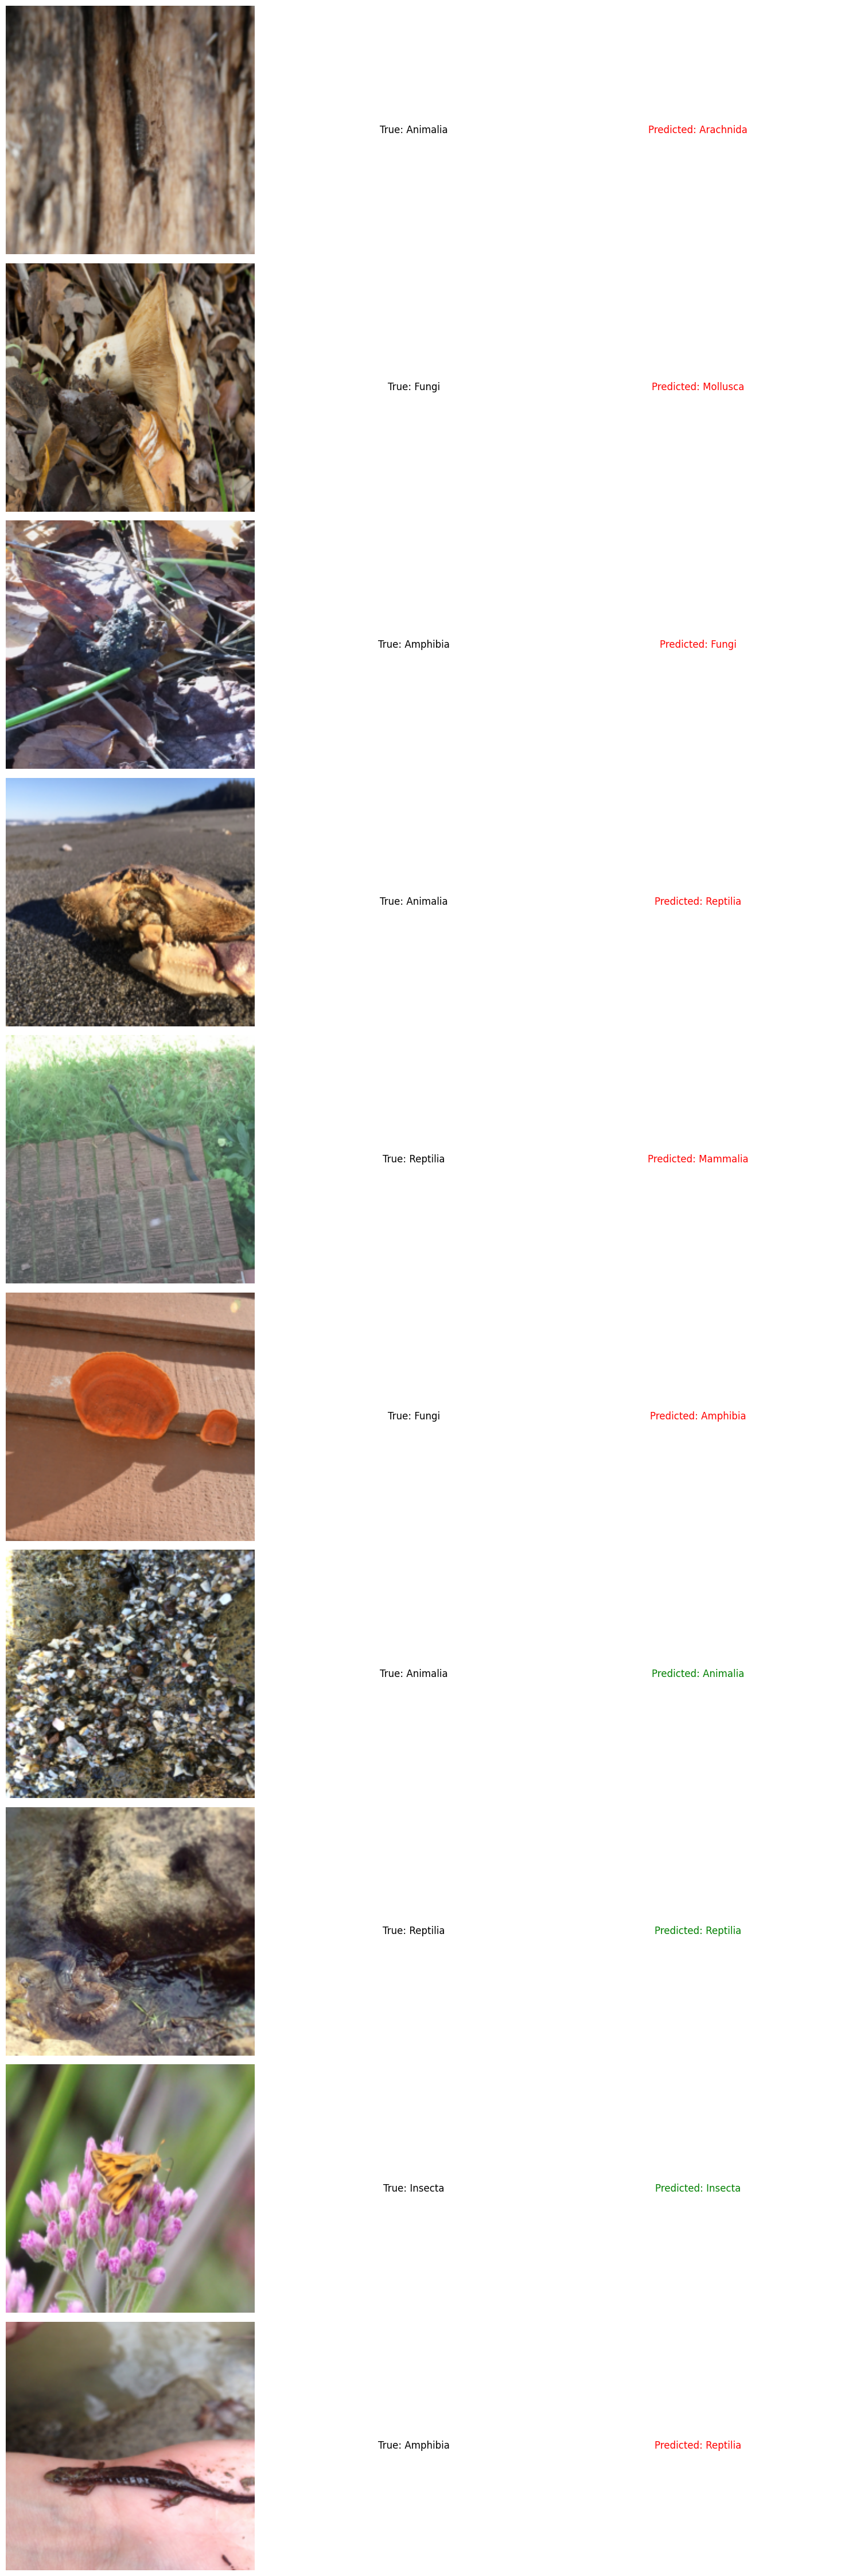

In [22]:

import matplotlib.pyplot as plt
images, labels = next(iter(test_loader))


wandb.init()

# Get a batch of test images and labels
images, labels = next(iter(test_loader))

# Load the best model weights
# model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Move to device if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
images = images.to(device)
labels = labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot predictions
fig, axes = plt.subplots(10, 3, figsize=(15, 45))

for i in range(10):
    img = images[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CxHxW → HxWxC
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)

    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')

    axes[i, 1].text(0.5, 0.5, f"True: {test_dataset.classes[labels[i].item()]}", 
                   ha='center', va='center', fontsize=12)
    axes[i, 1].axis('off')

    axes[i, 2].text(0.5, 0.5, f"Predicted: {test_dataset.classes[predicted[i].item()]}", 
                   ha='center', va='center', fontsize=12,
                   color='green' if predicted[i] == labels[i] else 'red')
    axes[i, 2].axis('off')

# Show the grid
plt.tight_layout()
plt.show()

wandb.log({"Test Predictions Grid": wandb.Image(fig)})
plt.close(fig)  # Close the figure to release memory